<a href="https://colab.research.google.com/github/mizzony/AFL/blob/main/Exploratory_Data_using_AFL_dataset_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the cleaned dataset
data = pd.read_csv('https://raw.githubusercontent.com/mizzony/AFL/refs/heads/main/AFL%20games%20margin.csv')
#data = pd.read_csv('https://raw.githubusercontent.com/mizzony/AFL/refs/heads/main/afl_data.csv')


#Explore the dataset
data.describe()
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2447 entries, 0 to 2446
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   GameId      2447 non-null   object 
 1   Year        2447 non-null   int64  
 2   Round       2447 non-null   object 
 3   Date        2447 non-null   object 
 4   MaxTemp     2440 non-null   float64
 5   MinTemp     2440 non-null   float64
 6   Rainfall    2425 non-null   float64
 7   Venue       2447 non-null   object 
 8   StartTime   2447 non-null   object 
 9   Attendance  2447 non-null   object 
 10  HomeTeam    2447 non-null   object 
 11  AwayTeam    2447 non-null   object 
 12  Margin      2447 non-null   int64  
 13  Win         2447 non-null   int64  
dtypes: float64(3), int64(3), object(8)
memory usage: 267.8+ KB


,GameId,Year,Round,Date,MaxTemp,MinTemp,Rainfall,Venue,StartTime,Attendance,HomeTeam,AwayTeam,Margin,Win
0,2012R0101,2012,R1,2012-03-24,24.0,12.2,0.0,Stadium Australia,7:20 PM,"38,203",Greater Western Sydney,Sydney,-63,0
1,2012R0102,2012,R1,2012-03-29,25.7,9.7,0.0,M.C.G.,7:45 PM,"78,285",Richmond,Carlton,-44,0
2,2012R0103,2012,R1,2012-03-30,27.4,9.7,0.0,M.C.G.,7:50 PM,"78,466",Hawthorn,Collingwood,22,1
3,2012R0104,2012,R1,2012-03-31,29.1,15.1,0.6,M.C.G.,1:45 PM,"33,473",Melbourne,Brisbane Lions,-41,0
4,2012R0105,2012,R1,2012-03-31,28.2,19.7,0.0,Carrara,3:45 PM,"12,790",Gold Coast,Adelaide,-69,0


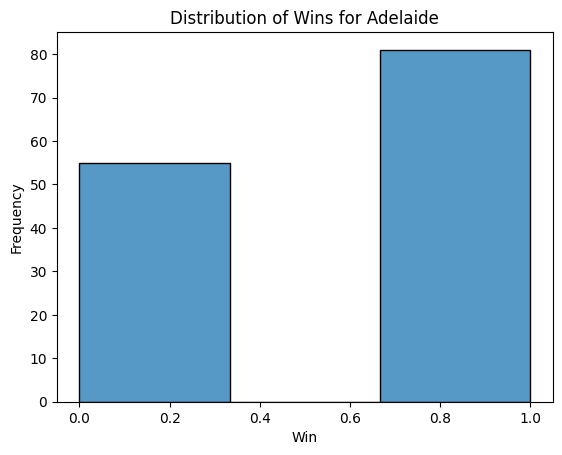

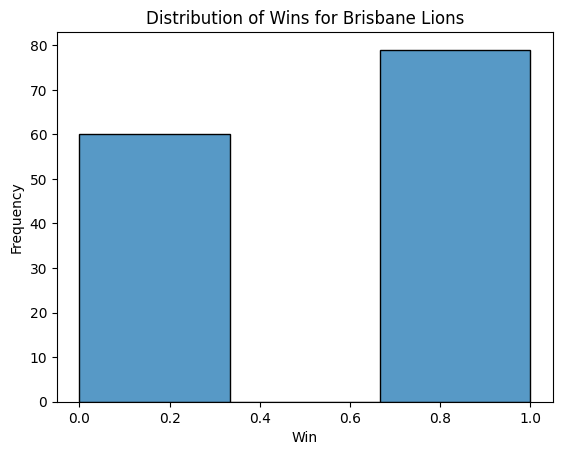

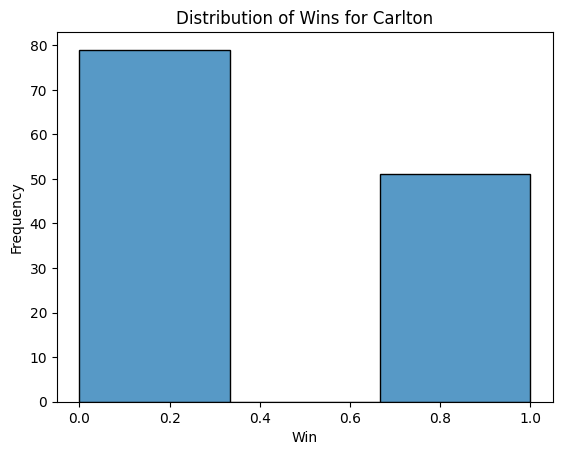

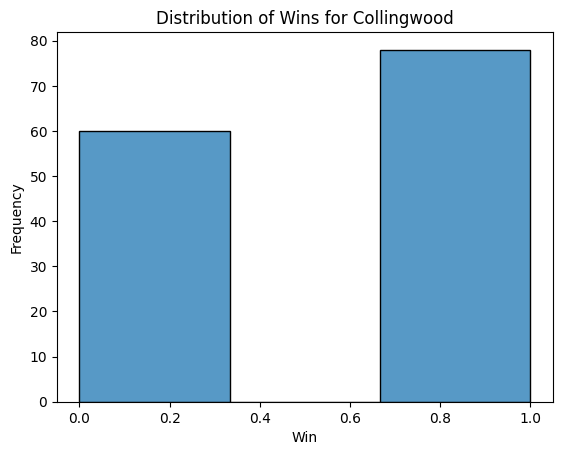

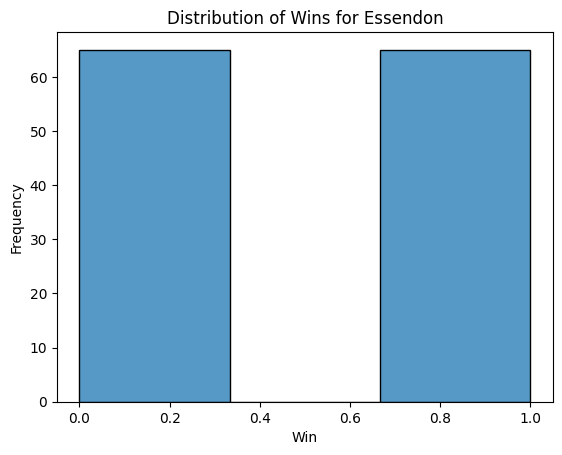

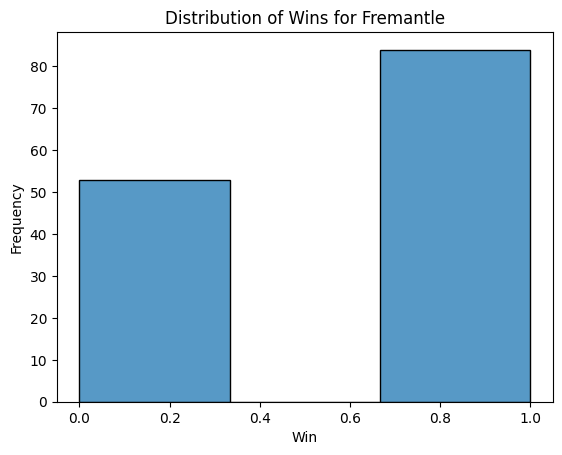

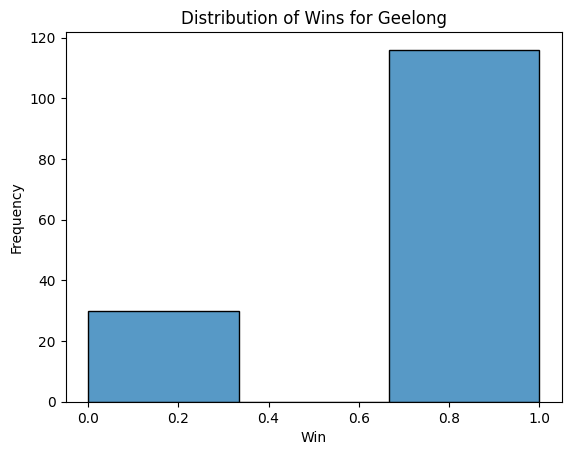

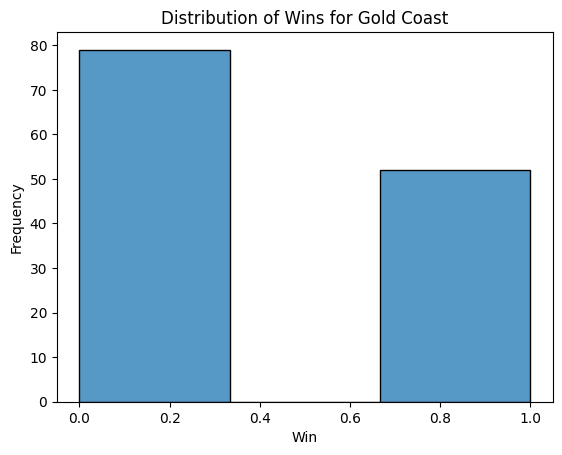

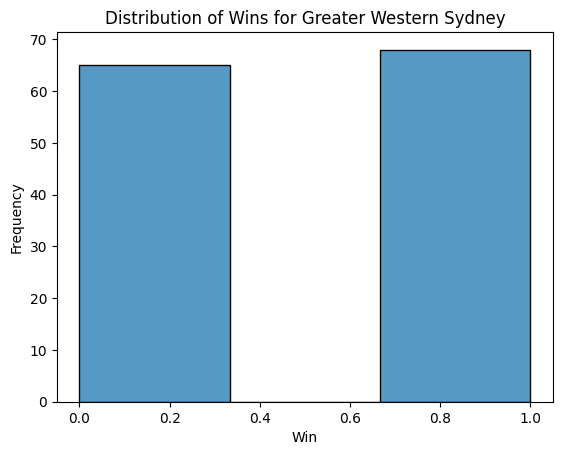

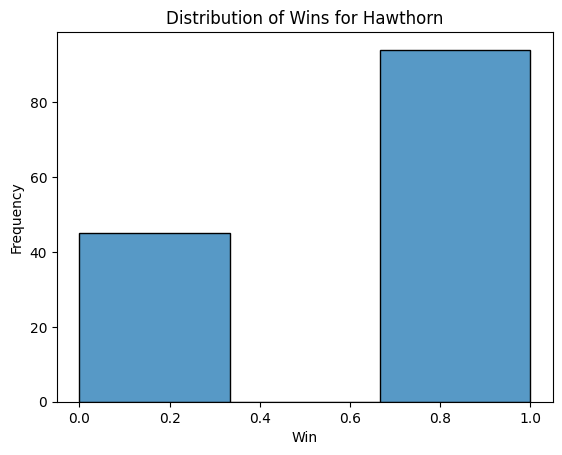

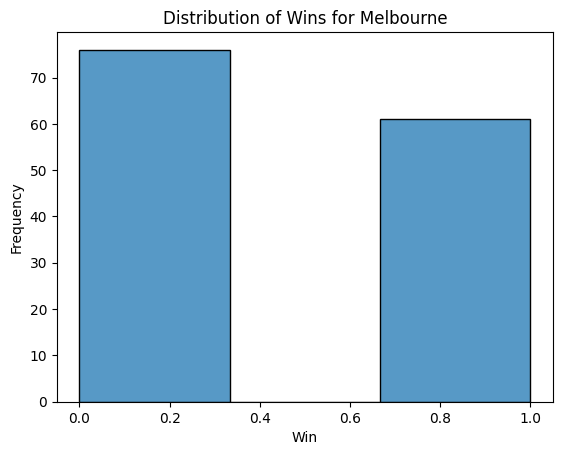

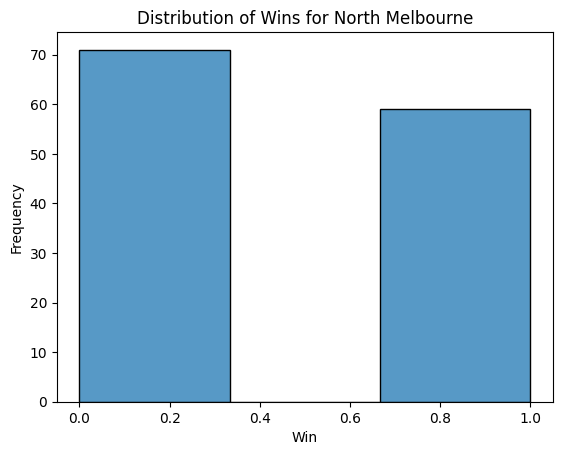

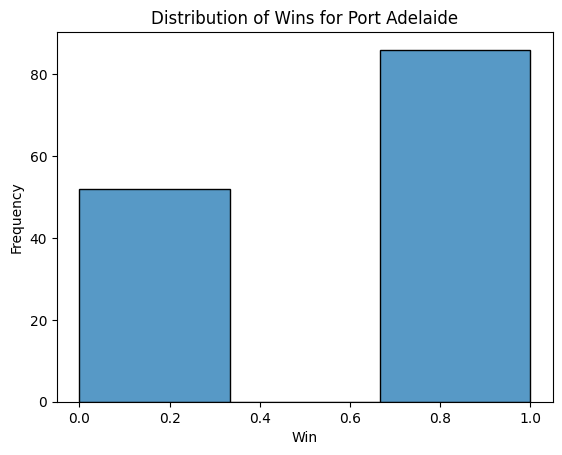

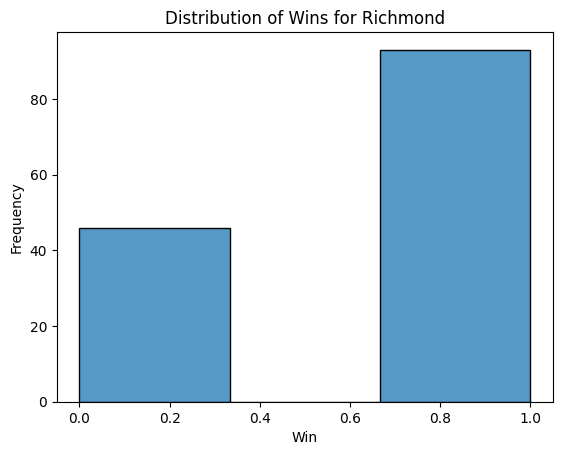

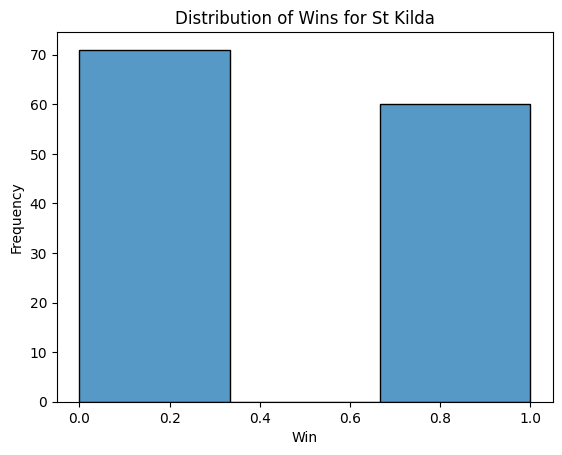

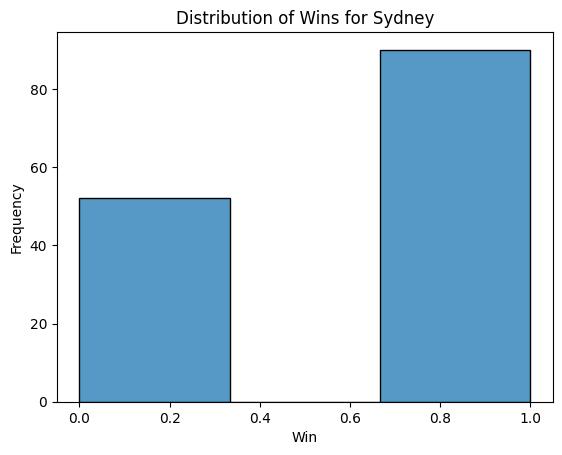

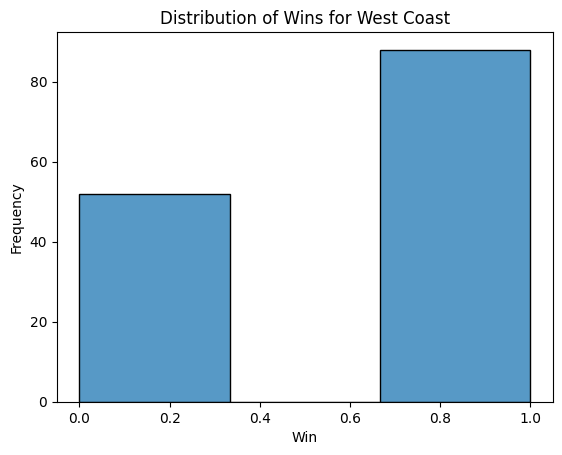

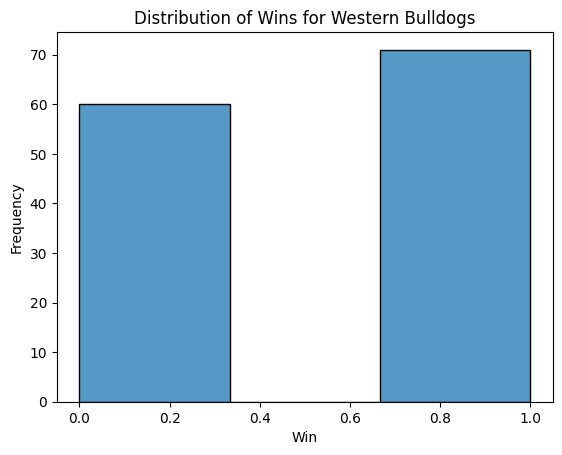

In [15]:

import seaborn as sns
import matplotlib.pyplot as plt

# Iterate through each HomeTeam and create a histogram for their Wins
for team, group in data.groupby('HomeTeam'):
    sns.histplot(group['Win'], bins= 3)  # Plot histogram for the 'Win' column within the group
    plt.title(f'Distribution of Wins for {team}')  # Set title for each subplot
    plt.xlabel('Win')  # Set x label 0 = lost, 1 =win
    plt.ylabel('Frequency')  # Set y-axis label
    plt.show()

HomeTeam
Geelong                   0.794521
Hawthorn                  0.676259
Richmond                  0.669065
Sydney                    0.633803
West Coast                0.628571
Port Adelaide             0.623188
Fremantle                 0.613139
Adelaide                  0.595588
Brisbane Lions            0.568345
Collingwood               0.565217
Western Bulldogs          0.541985
Greater Western Sydney    0.511278
Essendon                  0.500000
St Kilda                  0.458015
North Melbourne           0.453846
Melbourne                 0.445255
Gold Coast                0.396947
Carlton                   0.392308
Name: Win, dtype: float64


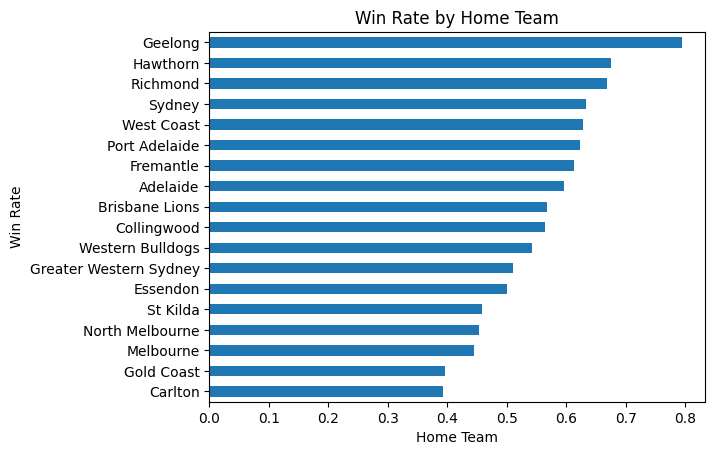

In [20]:
#calculate win rate for each home team
win_rate = data.groupby('HomeTeam')['Win'].mean().sort_values(ascending=True)
print(win_rate.sort_values(ascending=False))

#plot the win rate
win_rate.plot(kind='barh')
plt.title('Win Rate by Home Team')
plt.xlabel('Home Team')
plt.ylabel('Win Rate')
plt.show()

In [ ]:
#clean some data
pd.to_datetime(data['Date'])
data['Attendance'] = data['Attendance'].str.replace(',', '').astype(float) # Replace commas before conversion
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2447 entries, 0 to 2446
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   GameId      2447 non-null   object 
 1   Year        2447 non-null   int64  
 2   Round       2447 non-null   object 
 3   Date        2447 non-null   object 
 4   MaxTemp     2440 non-null   float64
 5   MinTemp     2440 non-null   float64
 6   Rainfall    2425 non-null   float64
 7   Venue       2447 non-null   object 
 8   StartTime   2447 non-null   object 
 9   Attendance  2447 non-null   float64
 10  HomeTeam    2447 non-null   object 
 11  AwayTeam    2447 non-null   object 
 12  Margin      2447 non-null   int64  
 13  Win         2447 non-null   int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 267.8+ KB


In [ ]:

# Features and target
X = data.drop(columns=['Win','Margin'])
#X = data.drop(columns=['Win'])
y = data['Win']

# Convert 'object' type columns to categorical
# Select object columns
object_cols = X.select_dtypes(include=['object']).columns

# Convert to categorical
for col in object_cols:
    X[col] = X[col].astype('category')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to DMatrix format for XGBoost
# Set enable_categorical=True to handle categorical features
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Set up XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 4,
    'eta': 0.1,
    'seed': 42
}

# Train the XGBoost model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Predict on the test set
y_pred_probs = bst.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

In [ ]:


# Create a new dataset with predictions and 'Win' column
# Reset index of X_test and y_test to ensure alignment with y_pred
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Create a copy of the test set and add predictions and the original 'Win' column
afl_data2 = X_test.copy()
afl_data2['Win'] = y_test
afl_data2['Predicted_Win'] = y_pred

# Print the new dataset with original and predicted values
print(afl_data2.head())

# Export the new dataset to a CSV file
afl_data2.to_csv('afl_data_with_predictions.csv', index=False)



      GameId  Year Round        Date  MaxTemp  MinTemp  Rainfall  \
0   2022EF01  2022    EF  2022-09-01     22.8     13.3       0.0   
1  2017R2306  2017   R23  2017-08-26     14.3      4.1       0.0   
2  2017R1509  2017   R15  2017-07-02     14.6      6.0      21.8   
3  2021R1706  2021   R17  2021-07-11     10.4     -1.0       0.2   
4  2016R0608  2016    R6  2016-05-01     16.8     14.0       9.8   

            Venue StartTime  Attendance                HomeTeam    AwayTeam  \
0           Gabba   7:20 PM     35013.0          Brisbane Lions    Richmond   
1   Adelaide Oval   7:10 PM     34288.0           Port Adelaide  Gold Coast   
2         Subiaco   2:40 PM     30541.0               Fremantle    St Kilda   
3  Eureka Stadium  12:40 PM      2952.0  Greater Western Sydney  Gold Coast   
4          M.C.G.   3:20 PM     43827.0                 Carlton    Essendon   

   Win  Predicted_Win  
0    1              0  
1    1              1  
2    0              1  
3    0              

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(report)

Accuracy: 0.5837
Confusion Matrix:
[[105 114]
 [ 90 181]]
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.48      0.51       219
           1       0.61      0.67      0.64       271

    accuracy                           0.58       490
   macro avg       0.58      0.57      0.57       490
weighted avg       0.58      0.58      0.58       490



In [ ]:
#take input from Users
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the cleaned dataset
data = pd.read_csv('https://raw.githubusercontent.com/mizzony/AFL/refs/heads/main/afl_data_2(droppoints).csv')
# Features and target
X = data.drop(columns=['Win'])  # Features
y = data['Win']  # Target (0 or 1)

# Convert 'object' type columns to categorical
object_cols = X.select_dtypes(include=['object']).columns

# Convert to categorical
for col in object_cols:
    X[col] = X[col].astype('category')

#convert one by one
#X['AwayTeam'] = X['AwayTeam'].astype('category')


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Set up XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 4,
    'eta': 0.1,
    'seed': 42
}

# Train the XGBoost model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Predict on the test set
y_pred_probs = bst.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

# Create a new dataset with predictions and the original 'Win' column
# Reset index of X_test and y_test to ensure alignment with y_pred
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Create a copy of the test set and add predictions and the original 'Win' column
afl_data2 = X_test.copy()
afl_data2['Win'] = y_test
afl_data2['Predicted_Win'] = y_pred

# Export the new dataset to a CSV file
afl_data2.to_csv('afl_data_with_predictions.csv', index=False)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(report)

# Take input for HomeTeam and AwayTeam and predict the outcome for the next round
home_team = input(str("Enter the Home Team: "))
away_team = input(str("Enter the Away Team: "))

# Create a new data frame for the prediction input
# Ensure the columns match the training data's columns in name and order
new_data = pd.DataFrame({
    'GameId': ['2024R0110'],  # Placeholder for GameId
    'Year': [2024],           # Year
    'Round': ['R1'],          # Round
    'Date': ['2024-03-15'],   # Placeholder for Date - Add a default value
    'MaxTemp': [25.0],        # Placeholder for Max Temperature
    'MinTemp': [15.0],        # Placeholder for Min Temperature
    'Rainfall': [2.14],        # Placeholder for Rainfall
    'Venue': ['M.C.G.'],  # Placeholder for Venue
    'StartTime': ['7:00 PM'], # Placeholder for Start Time
    'Attendance': [30000],    # Placeholder for Attendance
    'HomeTeam': [home_team],  # Home Team
    'AwayTeam': [away_team],  # Away Team

})

# Convert object type columns to categorical in new_data
for col in new_data.select_dtypes(include=['object']).columns:
    new_data[col] = new_data[col].astype('category')

# Convert new_data to DMatrix format
dnew = xgb.DMatrix(new_data, enable_categorical=True)

# Predict the outcome
new_pred_probs = bst.predict(dnew)
new_pred = [1 if prob > 0.5 else 0 for prob in new_pred_probs]

# Print the prediction
if new_pred[0] == 1:
    print(f'The predicted outcome for {home_team} vs {away_team} is: {home_team} will WIN.')
else:
    print(f'The predicted outcome for {home_team} vs {away_team} is: {away_team} will WIN.')


Accuracy: 0.59
Confusion Matrix:
[[ 97 122]
 [ 80 191]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.44      0.49       219
           1       0.61      0.70      0.65       271

    accuracy                           0.59       490
   macro avg       0.58      0.57      0.57       490
weighted avg       0.58      0.59      0.58       490

Enter the Home Team: Collingwood
Enter the Away Team: Richmond
The predicted outcome for Collingwood vs Richmond is: Richmond will WIN.


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the cleaned dataset
data = pd.read_csv('https://raw.githubusercontent.com/mizzony/AFL/refs/heads/main/afl_data_2(droppoints).csv')

# Check for imbalance in the dataset
print("Distribution of Win column in the dataset:")
print(data['Win'].value_counts())

# Balance the dataset by undersampling
class_0 = data[data['Win'] == 0]
class_1 = data[data['Win'] == 1]

# Check which class is larger and undersample accordingly
if len(class_0) > len(class_1):
    class_0 = class_0.sample(len(class_1), random_state=42)  # Undersample class_0
else:
    class_1 = class_1.sample(len(class_0), random_state=42)  # Undersample class_1

data_balanced = pd.concat([class_0, class_1])

# Update the features and target
X = data_balanced.drop(columns=['Win'])
y = data_balanced['Win']

print(y.value_counts())

# Convert 'object' type columns to categorical
object_cols = X.select_dtypes(include=['object']).columns

# Convert to categorical
for col in object_cols:
    X[col] = X[col].astype('category')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Set up XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 4,
    'eta': 0.1,
    'seed': 42
}

# Train the XGBoost model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Predict on the test set
y_pred_probs = bst.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

# Create a new dataset with predictions and the original 'Win' column
# Reset index of X_test and y_test to ensure alignment with y_pred
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Create a copy of the test set and add predictions and the original 'Win' column
afl_data2 = X_test.copy()
afl_data2['Win'] = y_test
afl_data2['Predicted_Win'] = y_pred

# Export the new dataset to a CSV file
afl_data2.to_csv('afl_data_with_predictions.csv', index=False)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(report)

# Take input for HomeTeam and AwayTeam and predict the outcome for the next round
home_team = input(str("Enter the Home Team: "))
away_team = input(str("Enter the Away Team: "))

# Create a new data frame for the prediction input
# Ensure the columns match the training data's columns in name and order
new_data = pd.DataFrame({
    'GameId': ['2024R0110'],  # Placeholder for GameId
    'Year': [2024],           # Year
    'Round': ['R1'],          # Round
    'Date': ['2024-03-15'],   # Placeholder for Date - Add a default value
    'MaxTemp': [25.0],        # Placeholder for Max Temperature
    'MinTemp': [15.0],        # Placeholder for Min Temperature
    'Rainfall': [2.14],       # Placeholder for Rainfall
    'Venue': ['M.C.G.'],      # Placeholder for Venue
    'StartTime': ['7:00 PM'], # Placeholder for Start Time
    'Attendance': [30000],    # Placeholder for Attendance
    'HomeTeam': [home_team],  # Home Team
    'AwayTeam': [away_team],  # Away Team
})

# Convert object type columns to categorical in new_data
for col in new_data.select_dtypes(include=['object']).columns:
    new_data[col] = new_data[col].astype('category')

# Convert new_data to DMatrix format
dnew = xgb.DMatrix(new_data, enable_categorical=True)

# Predict the outcome
new_pred_probs = bst.predict(dnew)
print(f'Predicted probabilities for the new data: {new_pred_probs}')
new_pred = [1 if prob > 0.5 else 0 for prob in new_pred_probs]

# Print the prediction
if new_pred[0] == 1:
    print(f'The predicted outcome for {home_team} vs {away_team} is: {home_team} will WIN.')
else:
    print(f'The predicted outcome for {home_team} vs {away_team} is: {away_team} will WIN.')


Distribution of Win column in the dataset:
Win
1    1376
0    1071
Name: count, dtype: int64
Accuracy: 0.58
Confusion Matrix:
[[ 99 112]
 [ 92 187]]
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.47      0.49       211
           1       0.63      0.67      0.65       279

    accuracy                           0.58       490
   macro avg       0.57      0.57      0.57       490
weighted avg       0.58      0.58      0.58       490

Enter the Home Team: Collingwood
Enter the Away Team: Geelong
Predicted probabilities for the new data: [0.2400906]
The predicted outcome for Collingwood vs Geelong is: Geelong will WIN.


In [ ]:
print("Distribution of Win column in the dataset:")
print(y.value_counts())

Distribution of Win column in the dataset:
Win
1    1376
0    1071
Name: count, dtype: int64


In [ ]:
# Balance the dataset by undersampling
class_0 = data[data['Win'] == 0]
class_1 = data[data['Win'] == 1]

# Check which class is larger and undersample accordingly
if len(class_0) > len(class_1):
    class_0 = class_0.sample(len(class_1), random_state=42)  # Undersample class_0
else:
    class_1 = class_1.sample(len(class_0), random_state=42)  # Undersample class_1

data_balanced = pd.concat([class_0, class_1])

# Update the features and target
X = data_balanced.drop(columns=['Win'])
y = data_balanced['Win']

print(y.value_counts())

Win
0    1071
1    1071
Name: count, dtype: int64


In [ ]:


# Convert 'object' type columns to categorical
object_cols = X.select_dtypes(include=['object']).columns

# Convert to categorical
for col in object_cols:
    X[col] = X[col].astype('category')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Set up XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 4,
    'eta': 0.1,
    'seed': 42
}

# Train the XGBoost model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Predict on the test set
y_pred_probs = bst.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

# Create a new dataset with predictions and the original 'Win' column
# Reset index of X_test and y_test to ensure alignment with y_pred
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Create a copy of the test set and add predictions and the original 'Win' column
afl_data2 = X_test.copy()
afl_data2['Win'] = y_test
afl_data2['Predicted_Win'] = y_pred

# Export the new dataset to a CSV file
afl_data2.to_csv('afl_data_with_predictions.csv', index=False)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(report)

# Take input for HomeTeam and AwayTeam and predict the outcome for the next round
home_team = input(str("Enter the Home Team: "))
away_team = input(str("Enter the Away Team: "))

# Create a new data frame for the prediction input
# Ensure the columns match the training data's columns in name and order
new_data = pd.DataFrame({
    'GameId': ['2024R0110'],  # Placeholder for GameId
    'Year': [2024],           # Year
    'Round': ['R1'],          # Round
    'Date': ['2024-03-15'],   # Placeholder for Date - Add a default value
    'MaxTemp': [25.0],        # Placeholder for Max Temperature
    'MinTemp': [15.0],        # Placeholder for Min Temperature
    'Rainfall': [2.14],       # Placeholder for Rainfall
    'Venue': ['M.C.G.'],      # Placeholder for Venue
    'StartTime': ['7:00 PM'], # Placeholder for Start Time
    'Attendance': [30000],    # Placeholder for Attendance
    'HomeTeam': [home_team],  # Home Team
    'AwayTeam': [away_team],  # Away Team
})

# Convert object type columns to categorical in new_data
for col in new_data.select_dtypes(include=['object']).columns:
    new_data[col] = new_data[col].astype('category')

# Convert new_data to DMatrix format
dnew = xgb.DMatrix(new_data, enable_categorical=True)

# Predict the outcome
new_pred_probs = bst.predict(dnew)
print(f'Predicted probabilities for the new data: {new_pred_probs}')
new_pred = [1 if prob > 0.5 else 0 for prob in new_pred_probs]

# Print the prediction
if new_pred[0] ==1 :
    print(f'The predicted outcome for {home_team} vs {away_team} is: {home_team} will WIN.')
else:
    print(f'The predicted outcome for {home_team} vs {away_team} is: {away_team} will WIN.')


Accuracy: 0.58
Confusion Matrix:
[[ 99 112]
 [ 92 187]]
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.47      0.49       211
           1       0.63      0.67      0.65       279

    accuracy                           0.58       490
   macro avg       0.57      0.57      0.57       490
weighted avg       0.58      0.58      0.58       490

Enter the Home Team: Collingwood
Enter the Away Team: Sydney
Predicted probabilities for the new data: [0.48207465]
The predicted outcome for Collingwood vs Sydney is: Sydney will WIN.


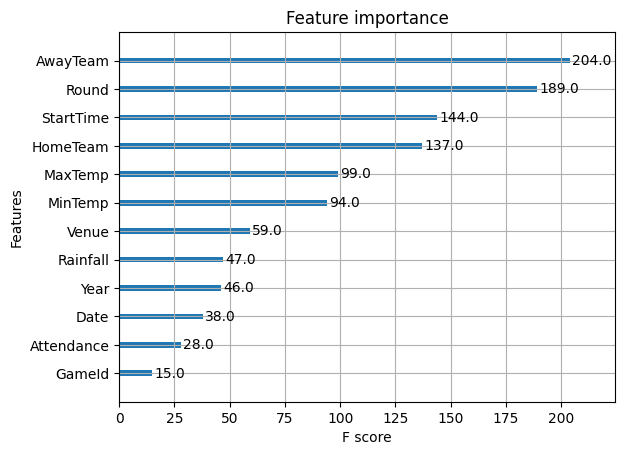

In [ ]:
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(bst)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Apply scaling to numerical columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [ ]:
new_data[numerical_cols] = scaler.transform(new_data[numerical_cols])


In [ ]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,                  # Increased depth
    'eta': 0.05,                     # Lower learning rate for finer adjustments
    'subsample': 0.8,                # Use a subset of data
    'colsample_bytree': 0.8,         # Use a subset of features
    'scale_pos_weight': 1,           # Adjust based on class imbalance
    'seed': 42
}

In [ ]:
#perform grid search
from sklearn.model_selection import GridSearchCV

# Convert DMatrix to regular dataset for GridSearchCV
X_train_df = pd.get_dummies(X_train)
xgb_model = xgb.XGBClassifier()

params = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0]
}

clf = GridSearchCV(xgb_model, params, scoring='accuracy', cv=3)
clf.fit(X_train_df, y_train)

print("Best Parameters:", clf.best_params_)


KeyboardInterrupt: 